In [1]:
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed

set_random_seed(0)

# Disable logging messages unless there is an error
set_log_level("ERROR")

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="Series.view is deprecated")

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [3]:
def reformat_forecast(forecast):
  forecast_data = []

  for i in range(8):
      step_col = f"step{i}"
      quantile_20_col = f"step{i} 20.0%"  # Column name for 20th percentile
      quantile_80_col = f"step{i} 80.0%"  # Column name for 80th percentile


      forecast_data.append({
          "ds": forecast["ds"].iloc[-1] + pd.Timedelta(hours=i),
          "yhat": forecast[step_col].iloc[-1],
          "yhat_lower": forecast[quantile_20_col].iloc[-1],  # Add lower bound (20th percentile)
          "yhat_upper": forecast[quantile_80_col].iloc[-1]   # Add upper bound (80th percentile)
      })

  new_forecast_df = pd.DataFrame(forecast_data)
  return new_forecast_df

In [4]:
# data = pd.read_csv('https://www.dropbox.com/scl/fi/ksf0nbmmiort5khbrgr61/allData.csv?rlkey=75e735fjk4ifttjt553ukxt3k&dl=1')
data = pd.read_csv('https://www.dropbox.com/scl/fi/s83jig4zews1xz7vhezui/allDataWithCalculatedColumns.csv?rlkey=9mm4zwaugxyj2r4ooyd39y4nl&raw=1')
data.ds = pd.to_datetime(data.ds)
data = data.sort_values('ds')
# data['y']=data['POD_GREEN_TBS']+data['POD_YELLOW_TBS']+data['POD_ORANGE_TBS']+data['TRG_HALLWAY_TBS']+data['RAZ_TBS']+data['AMBVERTTBS']+data['QTrack_TBS']+data['Garage_TBS']
data['y']=data['total_tbs']
df= data.copy()
# regressors='Inflow_Total'
# regressors = df.columns.tolist()
# regressors.remove('y')
# regressors.remove('ds')
# for col in regressors:
#     try:
#         df[col] = pd.to_numeric(df[col], errors='coerce')
#     except (ValueError, TypeError):
#         print(f"Warning: Could not convert column '{col}' to numeric. Skipping...")
# df = df[['ds','y', 'Inflow_Total']]
df.tail()


,ds,INFLOW_STRETCHER,Infl_Stretcher_cum,INFLOW_AMBULATORY,Infl_Ambulatory_cum,Inflow_Total,Inflow_Cum_Total,INFLOW_AMBULANCES,Infl_Ambulances_cum,FLS,...,RAZ_IMCONS_MORE4H,RAZ_XRAY_MORE2H,RAZ_CT_MORE2H1,PSYCH1,PSYCH_WAITINGADM,total_tbs,vert_tbs,pod_tbs,overflow,y
42323,2025-11-02 17:00:00,11,90,6,86,17,176,4,29,0,...,0,3,3,11,10,47,34,13,17,47
42324,2025-11-02 18:00:00,3,93,5,91,8,184,1,30,1,...,0,3,2,11,10,35,29,6,14,35
42325,2025-11-02 19:00:00,5,98,3,94,8,192,3,33,0,...,0,2,2,11,10,33,29,4,13,33
42326,2025-11-02 20:00:00,6,104,3,97,9,201,2,35,0,...,0,2,5,11,10,29,26,3,10,29
42327,2025-11-02 21:00:00,4,108,3,100,7,208,1,36,0,...,0,6,7,10,9,22,18,4,13,22


WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/nptesting/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():



WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/nptesting/lib/python3.12/site-packages/neuralprophet/data/process.py:496: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df.groupby("ID").apply(lambda x: x.set_index("ds").resample(freq).asfreq()).drop(columns=["ID"])

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/nptesting/lib/python3.12/site-packages/neuralprophet/data/process.py:517: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or e

Finding best initial lr:   0%|          | 0/265 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

        MAE      RMSE     Loss  RegLoss  epoch
9  5.201991  6.788021  0.05459      0.0      9


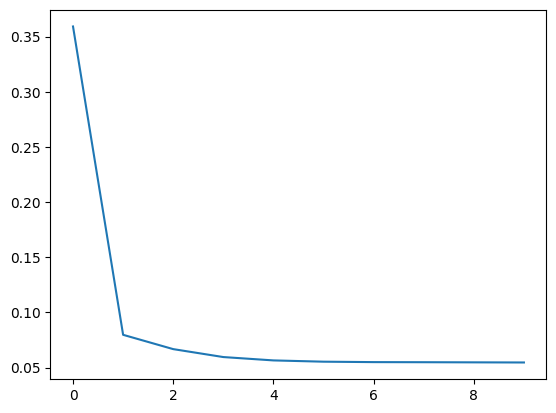

In [5]:
params = {
    'growth':'off',
    'yearly_seasonality': True,
    'weekly_seasonality': True,
    'daily_seasonality': True,
    'n_lags': 48,
    'n_forecasts': 8,
    'epochs':10,
    # 'changepoints_range': 0.95,
    # 'n_changepoints': 50,
    'quantiles': [0.2, 0.5, 0.8]
    # num_hidden_layers=4,
    # d_hidden=36,
    # learning_rate=0.005,

}

m = NeuralProphet(**params)
m.set_plotting_backend("plotly-static")
# m = m.add_lagged_regressor(names=regressors, n_lags=8)
# m = m.add_country_holidays("CA")
set_random_seed(42)
# metrics = m.fit(df, freq='h', progress='plot')
metrics = m.fit(df[['ds','y']], freq='h', progress='plot')


print(metrics.tail(1))

In [6]:
# df_future = m.make_future_dataframe(df, periods=8)
df_future = m.make_future_dataframe(df[['ds','y']], periods=8)
# print(df_future)
# forecast = m.predict(df_future)
forecast = m.predict(df_future, decompose=False, raw=True)
forecast

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/nptesting/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /Users/devinhopkins/anaconda3/envs/nptesting/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after group

Predicting: 331it [00:00, ?it/s]

,ds,step0,step0 20.0%,step0 80.0%,step1,step1 20.0%,step1 80.0%,step2,step2 20.0%,step2 80.0%,...,step4 80.0%,step5,step5 20.0%,step5 80.0%,step6,step6 20.0%,step6 80.0%,step7,step7 20.0%,step7 80.0%
0,2025-11-02 22:00:00,20.943571,18.857975,26.353504,19.292646,16.337963,23.888643,20.544344,15.986271,23.414679,...,22.14806,17.437054,14.849123,20.483479,15.268307,11.364209,18.936369,11.738272,7.659766,14.756706


In [7]:
output_df = reformat_forecast(forecast)
output_df

,ds,yhat,yhat_lower,yhat_upper
0,2025-11-02 22:00:00,20.943571,18.857975,26.353504
1,2025-11-02 23:00:00,19.292646,16.337963,23.888643
2,2025-11-03 00:00:00,20.544344,15.986271,23.414679
3,2025-11-03 01:00:00,20.402382,16.697544,23.208303
4,2025-11-03 02:00:00,19.428717,15.840726,22.148060
5,2025-11-03 03:00:00,17.437054,14.849123,20.483479
6,2025-11-03 04:00:00,15.268307,11.364209,18.936369
7,2025-11-03 05:00:00,11.738272,7.659766,14.756706


In [8]:
from neuralprophet import save


MODEL_VERSION = 1

save(m, f"../models/total_tbs-{MODEL_VERSION}.np")

In [9]:
# from neuralprophet import load
MODEL_VERSION = 1
# model = load(f"../models/total_tbs-{MODEL_VERSION}.np")